# 모듈 불러오기

In [23]:
import numpy as np
import pandas as pd

import random

from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold

import os
from glob import glob

import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

# 환경 설정하기

In [24]:
# GPU 할당
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)

cuda


In [91]:
# 하이퍼파라미터 튜닝
CFG = {
    'IMG_SIZE': 128,
    'EPOCHS': 5,
    'LEARNING_RATE': 0.001,
    'BATCH_SIZE': 16,
    'SEED': 41,
    'SPLIT': 5
}

In [92]:
# random seed 고정
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# 데이터 불러오기 & 처리하기

In [93]:
path = '/content/drive/MyDrive/Colab Notebooks/data/'

In [94]:
label_df = pd.read_csv(path + 'df_folds.csv')

label_df.head()

,file_name,label,fold
0,001.png,0,3
1,002.png,10,2
2,003.png,3,3
3,004.png,8,0
4,005.png,9,2


In [95]:
label_df["label"][0]

0

In [96]:
test_df = pd.read_csv(path + "test.csv")
test_df

,file_name
0,001.png
1,002.png
2,003.png
3,004.png
4,005.png
...,...
210,211.png
211,212.png
212,213.png
213,214.png


# split data

In [97]:
# skfolds = StratifiedKFold(n_splits=CFG['SPLIT'], random_state=CFG['SEED'], shuffle=True)

In [98]:
# label_df['fold'] = -1

# label_df

In [99]:
# X = label_df["file_name"]
# y = label_df["label"]

In [100]:
# for i, (trn_idx, vid_idx) in enumerate(skfolds.split(X, y)):
#     label_df.loc[vid_idx, 'fold'] = i

In [101]:
# label_df['fold'].value_counts()

In [102]:
# label_df.to_csv(path + "df_folds.csv", index=False)

# augmentation 정의하기

In [103]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [104]:
# image = cv2.imread(all_img_path[0])
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(image)

In [105]:
trn_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    A.OneOf([
            A.HorizontalFlip(p=1),
            A.RandomRotate90(p=1),
            A.VerticalFlip(p=1), 
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=1),           
    ], p=1),
    A.OneOf([
            A.MotionBlur(p=1),
            A.Blur(blur_limit=5, p=1),
            A.GaussNoise(p=1)                 
    ], p=1),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensor()
])

valid_transform = A.Compose([
   A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
   A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
   ToTensor()
])

Dataset 정의하기

In [106]:
class CustomDataset(Dataset):
  def __init__(self, path, train_df, train_mode=True, transforms=None): # 필요한 변수들을 선언
    self.transforms = transforms
    self.train_mode = train_mode
    self.path = path
    self.train_df = train_df

  def __getitem__(self, index): # index번째 data 리턴
    mode = 'train' if self.train_mode else 'test'

    img_path = self.path + mode + '/' + self.train_df["file_name"][index]

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transforms:
      image = self.transforms(image=image)["image"]

    if self.train_mode:
      label = self.train_df["label"][index]
      return image, label
    else:
      return image

  def __len__(self):
    return len(self.train_df)

# model 정의하기

In [107]:
from torchvision import models
from torchsummary import summary

In [108]:
CLASS_NUM = 11

In [109]:
class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.fc_layer = nn.Sequential( 
            nn.Linear(3136, 11) #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x) #1층
        
        x = self.layer2(x) #2층
         
        x = self.layer3(x) #3층
        
        x = self.layer4(x) #4층
        
        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열
        
        out = self.fc_layer(x)
        return out

In [110]:
efficientnet_b3 = models.efficientnet_b3(pretrained=False)

efficientnet_b3.fc = nn.Linear(1000, 11)

efficientnet_b3

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

# train loop 정의하기

In [111]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad() # gradient를 0으로 초기화

    # 예측
    pred = model(X)

    # 손실
    loss = loss_fn(pred, y)

    # 역전파
    loss.backward() # 예측 손실을 역전파
    optimizer.step() # 역전파 단계에서 수집된 변화도로 매개변수 조정

    if batch % 10 == 0:
      loss, current = loss.item(), batch * len(X) # dataset: 총 858개, batch_size = 16 -> 54개의 batch 존재
      print(f"loss: {loss:>7f}    [{current:>5d} / {size:>5d}]")

In [112]:
def validatation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0
    best_acc = 0
    model.eval()

    with torch.no_grad():
      for X, y in tqdm(iter(dataloader)):
        X, y = X.to(device), y.to(device)
        logit = model(X) # [bath_size, class_nums]
        
        valid_loss += loss_fn(logit, y)
        pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
        correct += pred.eq(y.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
      vali_acc = 100 * correct / size

      print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(valid_loss / len(dataloader), correct, size, 100 * correct / size))

      #베스트 모델 저장
      if best_acc < vali_acc:
        best_acc = vali_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/saved/best_model.pth') #이 디렉토리에 best_model.pth을 저장
        print('Model Saved.')

      return valid_loss.item()/len(dataloader)

In [113]:
train_dataset = CustomDataset(path, label_df[label_df['fold'] !=0].reset_index(), True, trn_transform)
valid_dataset = CustomDataset(path, label_df[label_df['fold'] == 0].reset_index(), True, valid_transform)

train_len = len(train_dataset)
valid_len = len(valid_dataset)

In [114]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) #BATCH_SIZE : 24
vali_loader = DataLoader(valid_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',valid_len, '/ total valid batches :', vali_batches)

total train imgs : 686 / total train batches : 43
total valid imgs : 172 / total valid batches : 11


In [115]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16]))

# train

In [ ]:
valid_loss_list = []

for i in range(CFG['SPLIT']):
  # Dataset
  train_dataset = CustomDataset(path, label_df[label_df['fold'] != i].reset_index(), True, trn_transform)
  valid_dataset = CustomDataset(path, label_df[label_df['fold'] == i].reset_index(), True, valid_transform)

  # Dataloader
  train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)
  valid_loader = DataLoader(valid_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

  # 모델 정의
  model = CNNclassification().to(device)
  # model = efficientnet_b3.to(device)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])

  print(f"+++++++++++++++++++++++ Fold: {i + 1} / {CFG['SPLIT']} +++++++++++++++++++++++")

  for i in range(1, CFG['EPOCHS'] + 1):
    print(f"Epoch {i}")
    train_loop(train_loader, model, criterion, optimizer)
    loss = validatation_loop(valid_loader, model, criterion)
    valid_loss_list.append(loss)
print("Done!")

+++++++++++++++++++++++ Fold: 1 / 5 +++++++++++++++++++++++
Epoch 1
loss: 2.398605    [    0 /   686]
loss: 2.404501    [  160 /   686]
loss: 2.404897    [  320 /   686]
loss: 2.400898    [  480 /   686]
loss: 2.399052    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3974, Accuracy: 15/172 ( 9%)

Model Saved.
Epoch 2
loss: 2.388045    [    0 /   686]
loss: 2.401026    [  160 /   686]
loss: 2.393437    [  320 /   686]
loss: 2.400850    [  480 /   686]
loss: 2.385051    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3973, Accuracy: 15/172 ( 9%)

Model Saved.
Epoch 3
loss: 2.396741    [    0 /   686]
loss: 2.399629    [  160 /   686]
loss: 2.411219    [  320 /   686]
loss: 2.390752    [  480 /   686]
loss: 2.391066    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3973, Accuracy: 15/172 ( 9%)

Model Saved.
Epoch 4
loss: 2.384149    [    0 /   686]
loss: 2.390278    [  160 /   686]
loss: 2.410690    [  320 /   686]
loss: 2.410029    [  480 /   686]
loss: 2.396028    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3973, Accuracy: 15/172 ( 9%)

Model Saved.
Epoch 5
loss: 2.392376    [    0 /   686]
loss: 2.394237    [  160 /   686]
loss: 2.379772    [  320 /   686]
loss: 2.407346    [  480 /   686]
loss: 2.392253    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3971, Accuracy: 15/172 ( 9%)

Model Saved.
+++++++++++++++++++++++ Fold: 2 / 5 +++++++++++++++++++++++
Epoch 1
loss: 2.397268    [    0 /   686]
loss: 2.414298    [  160 /   686]
loss: 2.398557    [  320 /   686]
loss: 2.403961    [  480 /   686]
loss: 2.396535    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3973, Accuracy: 16/172 ( 9%)

Model Saved.
Epoch 2
loss: 2.406425    [    0 /   686]
loss: 2.385951    [  160 /   686]
loss: 2.395112    [  320 /   686]
loss: 2.407884    [  480 /   686]
loss: 2.394367    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3971, Accuracy: 16/172 ( 9%)

Model Saved.
Epoch 3
loss: 2.399532    [    0 /   686]
loss: 2.396419    [  160 /   686]
loss: 2.389600    [  320 /   686]
loss: 2.397511    [  480 /   686]
loss: 2.398301    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3969, Accuracy: 16/172 ( 9%)

Model Saved.
Epoch 4
loss: 2.399534    [    0 /   686]
loss: 2.396150    [  160 /   686]
loss: 2.388755    [  320 /   686]
loss: 2.395252    [  480 /   686]
loss: 2.395101    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3969, Accuracy: 16/172 ( 9%)

Model Saved.
Epoch 5
loss: 2.393342    [    0 /   686]
loss: 2.394668    [  160 /   686]
loss: 2.399228    [  320 /   686]
loss: 2.388490    [  480 /   686]
loss: 2.401166    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3967, Accuracy: 16/172 ( 9%)

Model Saved.
+++++++++++++++++++++++ Fold: 3 / 5 +++++++++++++++++++++++
Epoch 1
loss: 2.401803    [    0 /   686]
loss: 2.407099    [  160 /   686]
loss: 2.398675    [  320 /   686]
loss: 2.392618    [  480 /   686]
loss: 2.404068    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3977, Accuracy: 16/172 ( 9%)

Model Saved.
Epoch 2
loss: 2.397266    [    0 /   686]
loss: 2.389883    [  160 /   686]
loss: 2.394934    [  320 /   686]
loss: 2.400091    [  480 /   686]
loss: 2.396473    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3973, Accuracy: 16/172 ( 9%)

Model Saved.
Epoch 3
loss: 2.392800    [    0 /   686]
loss: 2.389807    [  160 /   686]
loss: 2.404434    [  320 /   686]
loss: 2.399251    [  480 /   686]
loss: 2.391093    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3970, Accuracy: 16/172 ( 9%)

Model Saved.
Epoch 4
loss: 2.390289    [    0 /   686]
loss: 2.398368    [  160 /   686]
loss: 2.401707    [  320 /   686]
loss: 2.402118    [  480 /   686]
loss: 2.396051    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3969, Accuracy: 16/172 ( 9%)

Model Saved.
Epoch 5
loss: 2.403317    [    0 /   686]
loss: 2.399138    [  160 /   686]
loss: 2.389186    [  320 /   686]
loss: 2.392686    [  480 /   686]
loss: 2.399701    [  640 /   686]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3965, Accuracy: 16/172 ( 9%)

Model Saved.
+++++++++++++++++++++++ Fold: 4 / 5 +++++++++++++++++++++++
Epoch 1
loss: 2.399070    [    0 /   687]
loss: 2.395205    [  160 /   687]
loss: 2.396023    [  320 /   687]
loss: 2.392089    [  480 /   687]
loss: 2.400221    [  640 /   687]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3978, Accuracy: 15/171 ( 9%)

Model Saved.
Epoch 2
loss: 2.398054    [    0 /   687]
loss: 2.396091    [  160 /   687]
loss: 2.395876    [  320 /   687]
loss: 2.401498    [  480 /   687]
loss: 2.401765    [  640 /   687]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3976, Accuracy: 15/171 ( 9%)

Model Saved.
Epoch 3
loss: 2.392593    [    0 /   687]
loss: 2.400954    [  160 /   687]
loss: 2.399223    [  320 /   687]
loss: 2.397341    [  480 /   687]
loss: 2.400038    [  640 /   687]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3976, Accuracy: 15/171 ( 9%)

Model Saved.
Epoch 4
loss: 2.392523    [    0 /   687]
loss: 2.401389    [  160 /   687]
loss: 2.392114    [  320 /   687]
loss: 2.397474    [  480 /   687]
loss: 2.400188    [  640 /   687]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3974, Accuracy: 15/171 ( 9%)

Model Saved.
Epoch 5
loss: 2.397274    [    0 /   687]
loss: 2.390236    [  160 /   687]
loss: 2.397842    [  320 /   687]
loss: 2.398419    [  480 /   687]
loss: 2.391824    [  640 /   687]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3976, Accuracy: 15/171 ( 9%)

Model Saved.
+++++++++++++++++++++++ Fold: 5 / 5 +++++++++++++++++++++++
Epoch 1
loss: 2.398539    [    0 /   687]
loss: 2.398445    [  160 /   687]
loss: 2.385116    [  320 /   687]
loss: 2.397480    [  480 /   687]
loss: 2.397579    [  640 /   687]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3987, Accuracy: 15/171 ( 9%)

Model Saved.
Epoch 2
loss: 2.398392    [    0 /   687]
loss: 2.392864    [  160 /   687]
loss: 2.399151    [  320 /   687]
loss: 2.397243    [  480 /   687]
loss: 2.398994    [  640 /   687]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3986, Accuracy: 15/171 ( 9%)

Model Saved.
Epoch 3
loss: 2.403784    [    0 /   687]
loss: 2.400033    [  160 /   687]
loss: 2.398610    [  320 /   687]
loss: 2.394490    [  480 /   687]
loss: 2.401254    [  640 /   687]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3987, Accuracy: 15/171 ( 9%)

Model Saved.
Epoch 4
loss: 2.401126    [    0 /   687]
loss: 2.402889    [  160 /   687]
loss: 2.402588    [  320 /   687]
loss: 2.396541    [  480 /   687]
loss: 2.398545    [  640 /   687]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3982, Accuracy: 15/171 ( 9%)

Model Saved.
Epoch 5
loss: 2.400242    [    0 /   687]
loss: 2.398068    [  160 /   687]
loss: 2.407592    [  320 /   687]
loss: 2.395906    [  480 /   687]
loss: 2.396835    [  640 /   687]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.3983, Accuracy: 15/171 ( 9%)

Model Saved.
Done!


In [ ]:
# summary(model, (3, CFG['IMG_SIZE'], CFG['IMG_SIZE']))

In [89]:
valid_loss_list

[2.3948088559237393,
 2.394229195334695,
 2.393821369517933,
 2.39245588129217,
 2.3914982188831675,
 2.3954585682262075,
 2.393914656205611,
 2.3926396803422407,
 2.3908051577481357,
 2.3893925059925425,
 2.3961746909401636,
 2.394654534079812,
 2.3939992731267754,
 2.393485329367898,
 2.393151716752486,
 2.3929836966774682,
 2.390827178955078,
 2.389113339510831,
 2.3874799554998223,
 2.3867367831143467,
 2.3962249755859375,
 2.395292108709162,
 2.3947864879261362,
 2.3938976634632456,
 2.392367276278409]

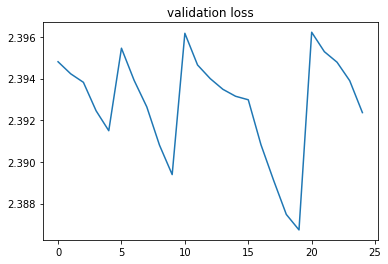

In [90]:
x_values = list(range(len(valid_loss_list)))
y_values = valid_loss_list

plt.title("validation loss")
plt.plot(x_values, y_values)
plt.show()

# 추론하기

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
test_dataset = CustomDataset(path, test_df, train_mode=False, transforms=valid_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/saved/best_model.pth')
# model = CNNclassification().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)
preds[0:5]

  0%|          | 0/14 [00:00<?, ?it/s]

[1, 1, 1, 9, 9]

# 제출하기

In [ ]:
submission = pd.read_csv(path + 'sample_submission.csv')
submission['label'] = preds

In [ ]:
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
submission.head()

,file_name,label
0,001.png,1
1,002.png,1
2,003.png,1
3,004.png,9
4,005.png,9


In [ ]:
submission.to_csv(path+'submit2.csv', index=False)